In [105]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [108]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [109]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")
#print(X.groupby(['Target']).count())
X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0.0).sum())
print("Positive Examples : ",(X['Target']==1.0).sum())
print("Neutral Examples : ",(X['Target']==2.0).sum())


Number of Examples :  34125 

Number of Examples after removing duplicates:  33921 

Number of words before cleaning :  1305539
Number of words after cleaning :  878498

******************

Negative Examples :  3905
Positive Examples :  11822
Neutral Examples :  18194


In [110]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

0        krato present canaccord virtual growth confer ...
1        pyxi tanker announc date releas second quarter...
2        intellig system announc new board member norcr...
3        vianet group inc announc unaudit second quarte...
4        rewalk robot report second quarter financi res...
                               ...                        
33916    borg warner investig initi former louisiana at...
33917    bayer hour deadlin alert former louisiana atto...
33918    cantor fitzgerald bgc partner chariti day virt...
33919    chariti day virtual unstopp bgc partner cantor...
33920    halo lab provid oregon busi updat toronto busi...
Name: Article, Length: 33921, dtype: object


In [111]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']


print("Neutral Examples in Training after OverSampling: ",(train['Target']==2).sum())
print("Negative Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train['Target']==1).sum())

train.to_csv (r'General1.csv', index = False, header=True)
test.to_csv (r'General2.csv', index = False, header=True)
val.to_csv (r'General3.csv', index = False, header=True)

Neutral Examples in Training after OverSampling:  10189
Negative Examples in Training after OverSampling:  10189
Positive Examples in Training after OverSampling:  10189


In [112]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General1.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'General2.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'General3.csv',format = 'csv',fields = fields,skip_header = True)


TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))   



Size of TEXT vocabulary: 21116
Size of LABEL vocabulary: 3
[('stock', 14237), ('earn', 11039), ('compani', 7484), ('report', 7222), ('inc', 6841), ('announc', 5635), ('result', 4890), ('share', 4353), ('investor', 4116), ('busi', 4097)]


In [113]:
def find_accuracy(preds, y):
   
    temp = torch.log_softmax(preds, dim = 1)
    _, y_pred = torch.max(temp, dim = 1) 
    valid = (y_pred == y).float() 
    accur = valid.sum() / len(valid)
    return accur,y_pred,y

def Loss_Optimizer (model,valueLR):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [114]:
def train(model,data,lr,optimizer,criterion):
        
    #optimizer,criterion=Loss_Optimizer (model,lr)
    #criterion = criterion.to(device)
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(0)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [115]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(0)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [116]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1, 2])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix, with normalization')
    

In [117]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

In [118]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [119]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        return self.fc(hidden)

In [120]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [121]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 3
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(21116, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(21116, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch :  5  Train Loss :  0.36827933279176556   Train Acc :  0.8562829991181692   Valid Loss :  0.5601684987545014  Val Acc :  0.80273916721344
Epoch :  10  Train Loss :  0.19775491741796333   Train Acc :  0.9257086714108785   Valid Loss :  0.6938901513814926  Val Acc :  0.8206989407539368
Epoch :  15  Train Loss :  0.13012312489251296   Train Acc :  0.951187272866567   Valid Loss :  0.8641391098499298  Val Acc :  0.82684246301651
Epoch :  20  Train Loss :  0.08719628125739594   Train Acc :  0.9676432291666667   Valid Loss :  1.0352305710315703  Val Acc :  0.8267847418785095
Epoch :  25  Train Loss :  0.0652331193520998   Train Acc :  0.9760033965110779   Valid Loss :  1.1122539281845092  Val Acc :  0.82516450881958
Epoch :  30  Train Loss :  0.04989325815501312   Train Acc :  0.9820466478665669   Valid Loss :  1.2675769209861756  Val Acc :  0.8199799060821533

Time needed for Training :  2.8530151804288226

Loss in Testset :  0.9284399926662446   Accuracy in Testset :  0.8264680981636

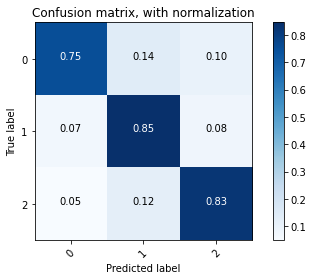

In [122]:
process_test(new_model2,30,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","best_LSTM_1_model.pt")

Epoch :  5  Train Loss :  0.39396464079618454   Train Acc :  0.846364293495814   Valid Loss :  0.5386967658996582  Val Acc :  0.8067829966545105
Epoch :  10  Train Loss :  0.23670922952393691   Train Acc :  0.9074240783850352   Valid Loss :  0.6468876600265503  Val Acc :  0.8199488043785095
Epoch :  15  Train Loss :  0.16591001041233538   Train Acc :  0.9393325964609782   Valid Loss :  0.701705914735794  Val Acc :  0.8221238613128662
Epoch :  20  Train Loss :  0.10794596302633484   Train Acc :  0.9597484707832337   Valid Loss :  0.8306649684906006  Val Acc :  0.8364615321159363
Epoch :  25  Train Loss :  0.08368971251572171   Train Acc :  0.9695906360944112   Valid Loss :  0.927523797750473  Val Acc :  0.8265005946159363
Epoch :  30  Train Loss :  0.06756201043414573   Train Acc :  0.9755859375   Valid Loss :  1.0121300041675567  Val Acc :  0.8284537196159363

Time needed for Training :  2.319788897037506

Loss in Testset :  0.853668861836195   Accuracy in Testset :  0.8290583789348602

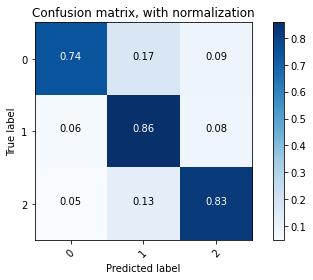

In [123]:
process_test(new_model3,30,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","best_gru_1_model.pt")